# CAB420 Linear Regression, Example 1: Linear Regression
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
This example explores multiple linear regression, and looks at how we can debug/diagnose models.

Please also be aware that there are a large number of ways to do this in python. The pandas and statsmodels approach here is not the only way, and you are welcome to use other packages as you see fit. For the most part in CAB420, we will be using SKLearn, but the output provided by statsmodels here is a little more nicely presented.

## Too Long; Didn't Read:
We can compute a linear regression model in Python using statsmodels. We can also do it using sklearn, and a bunch of other packages, but we're using statsmodels.
* A linear regression model makes a couple of assumptions, that our predictors are indepedant, and that residuals form a gaussian disribution
* When analysiing a models performance, we can use a number of tools to consider the importance of individual terms, and the validity of the whole model
* On an individual term level, the p-value is the most useful, and is the p-value for the null hypothesis that the coefficient is equal to 0.  A low p-value means that you can reject the null hypothesis, i.e. that the term is significant and thus important to the model.
* If the p-value is high (i.e. the term is not sigificant), there are two main reasons for this. 
  * 1) the predictor term and the response aren't related, and thus one has no bearing on the other, in which case the term probably shouldn't be in the model; 
  * 2) the predictor term is correlated with another predictor, and thus the relationship between that variable and the response is (to some extent) captured twice in the model. 
* In either of the above situations, using correlation can help identify what's going on to improve the model
* On a whole of model level, the $R^2$ and RMSE are useful values to consider. 
  * The $R^2$ indicates how much of the total variation in the data is captured by the model, with a value of 0 indicating that the model captures nothing, and a value of 1 indicating that the model captures everything. While 1 is ideal performance, an $R^2$ of 1 may also indicate overfitting. **The $R^2$ can only be calculated on the training data.**
  * The RMSE (root mean squared error) is a measure of prediction error, i.e. how much the model is out by when comapred to the true values. Smaller RMSEs are better. The scale of the RMSE is not fixed, and depends on the data itself. RMSE can also be computed on training, validation and testing sets.
* Again considering the whole model, analysising residuals is also a powerful tool. We have a number of assumptions around our residuals; namely that they follow a normal distibution and follow a constant distribution across the range of predicted values. QQ-plots, which plot the residuals against what's expected, hisotrams of the residuals, and scatter plots of the predicted values vs the residuals all help check these assumptions.
* Categorical varaibles can also be included in a model, but are captured diffently to regular continuous variables
* We can add terms that are the products of existing terms (higher order terms) and while this can help improve performance, if we go too far it can lead to overfitting.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

import statsmodels.api
import statsmodels.formula.api as sm
import scipy.stats as stats

### Data Pre-Processing 

We're going to use pandas to read our data. This will load our data into a pandas dataframe, and easy to index and slice as needed.

For those who are uncertain about Pandas and DataFrames, the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) is a good place to start.

In [2]:
data = pandas.read_csv('../data/washingtonbikeshare/day.csv')
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


The data that we're using comes from the Washington DC Bike Share scheme. In particular, we have data from 2011 and 2012, and it captures: 
* The date, and some other data around that such as the season (summer, winter, etc), month, day of the week, if it's a workday
* The weather, in terms of the temperature, apparent temperature (i.e. the "feels like" temperature), humidity, windspeed and another categorical that captures the overall "weather type" for the day
* The number of cyclists, broken down into registered and casual users

We're going to try and predict the total number of cyclists given the weather. As a sanity check, let's plot the number of cyclists over time.

Text(0.5, 1.0, 'Total Cyclists over Time')

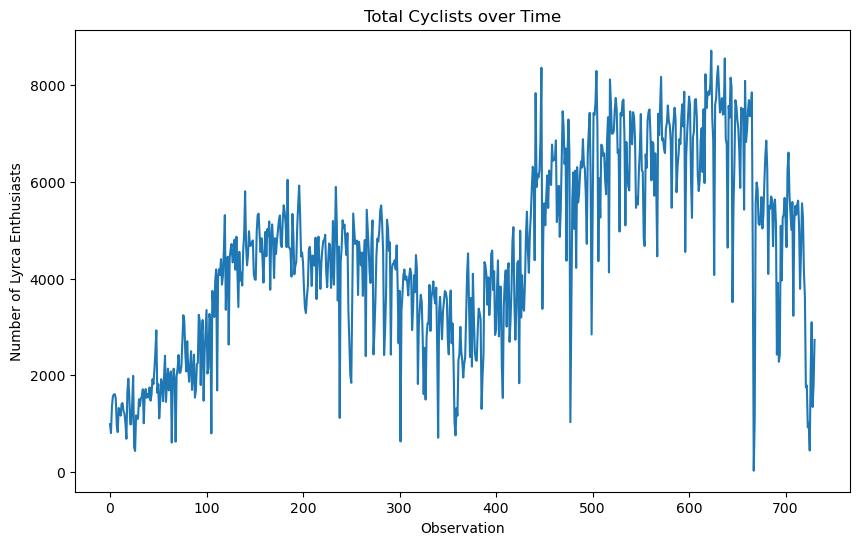

In [3]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(data['cnt'])
ax.set_xlabel('Observation')
ax.set_ylabel('Number of Lyrca Enthusiasts')
ax.set_title('Total Cyclists over Time')

We can see a pretty clear shift in usage from one year to the next, with greater usage in the second year. We'll select just data from the first year to make the data a little more consistent.

We'll split our data into two chunks:
* Our training set will be the first 9 months of the first year
* Our testing set will be the final 3 months of the first year

In [4]:
data_train = data.loc[(data['yr'] == 0) & (data['mnth'] < 10)]
data_test = data.loc[(data['yr'] == 0) & (data['mnth'] >= 10)]
print(data_train.shape)
print(data_test.shape)

(273, 16)
(92, 16)


For the sake of sanity, we can check the size of those two arrays to make sure that we have the expected amount of data in each.

We'll also check the correlation between our target variable and the predictors. We're going to start with just using our weather values, so we'll focus on those four terms and their correlation with the total number of cyclists.

Text(0.5, 1.0, '-0.2849121836502259')

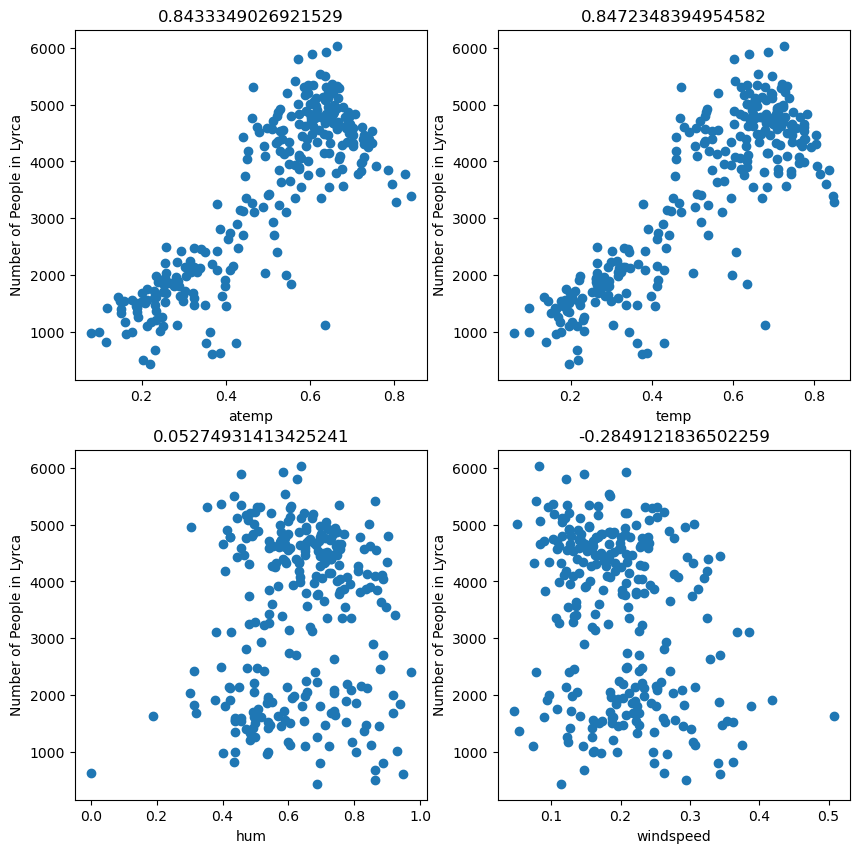

In [5]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(2, 2, 1)
ax.scatter(data_train['atemp'], data_train['cnt'])
ax.set_xlabel('atemp')
ax.set_ylabel('Number of People in Lyrca')
ax.set_title(str(data_train['cnt'].corr(data_train['atemp'])))

ax = fig.add_subplot(2, 2, 2)
ax.scatter(data_train['temp'], data_train['cnt'])
ax.set_xlabel('temp')
ax.set_ylabel('Number of People in Lyrca')
ax.set_title(str(data_train['cnt'].corr(data_train['temp'])))

ax = fig.add_subplot(2, 2, 3)
ax.scatter(data_train['hum'], data_train['cnt'])
ax.set_xlabel('hum')
ax.set_ylabel('Number of People in Lyrca')
ax.set_title(str(data_train['cnt'].corr(data_train['hum'])))

ax = fig.add_subplot(2, 2, 4)
ax.scatter(data_train['windspeed'], data_train['cnt'])
ax.set_xlabel('windspeed')
ax.set_ylabel('Number of People in Lyrca')
ax.set_title(str(data_train['cnt'].corr(data_train['windspeed'])))

There seems to be a relationship between each of our variables and our target. Though it's much stronger for the two temperature variables. One thing to note is that there is also a relationship between some of our variables, in particular atemp and temp.

Text(0.5, 1.0, '0.9968816302544009')

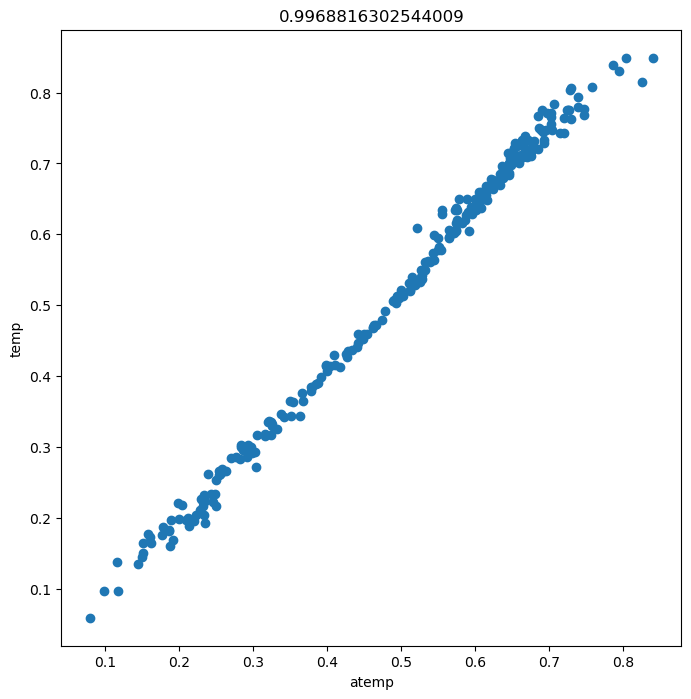

In [6]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data_train['atemp'], data_train['temp'])
ax.set_xlabel('atemp')
ax.set_ylabel('temp')
ax.set_title(str(data_train['atemp'].corr(data_train['temp'])))

From the scatter plot, we can see that these two variables are very highly correlated. This will be a problem, which we'll see in a little while.

## A Simple Model
On to our model fitting now. We can specify this in a number of ways, but for visual clarity we'll use a formula based on the variable names in the dataframe.

What we're asking here is for the model to esimate `cnt` using the combination of `atemp`, `temp`, `hum` and `windspeed`.

In [7]:
model = sm.ols(formula="cnt ~ atemp + temp + hum + windspeed", data=data_train).fit()
print(model.params)

Intercept    1708.845113
atemp       -3132.556967
temp         8823.664422
hum         -1134.940953
windspeed   -3052.918412
dtype: float64


statsmodels will give us a pretty comprehensive breakdown of our model. This gives us a lot of good info about the overall model and individual terms (coefficients).

In [8]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     198.4
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           8.06e-79
Time:                        07:39:54   Log-Likelihood:                -2190.2
No. Observations:                 273   AIC:                             4390.
Df Residuals:                     268   BIC:                             4408.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1708.8451    296.956      5.755      0.0

Focussing on the coefficients first, we have the following:
* coef: The estimate of the parameter
* std err: The standard error, a measure of how much the coefficient changes by if we resample the data and recompute the regression
* t: the tStat, $\frac{coeff}{std err}$, we want this to be a long way from 0, as it indicates that the term is less likely to be the result of noise
* P: p-value for the null hypothesis that the coefficient is equal to 0. A low p-value means that you can reject the null hypothesis, i.e. that the term is significant.
We also get some confidence intervals for the parameters.

From this we see that the humidy and windspeed variables are more significant than our temperature variables. However, the scatter plots suggest that temperature is more important - both in terms of having a stronger visual trend and a higher correlation. We'll get back to why this is the case in a little bit.

We also get some other "whole of model" details. These are:
* No. observations: how many samples we have, in general, more is better (to a point, things get trickier when we can't fit the data in memory)
* Df Residuals: This is one minus the number of parameters we are learning. If this is too small, we run a greater risk of overfitting           
* R-Squared: Proportion of observed variance explained by the model. A value of $1$ means the model explains everything, a value of $0$ means it explains nothing. Defined as follows:
  * $R^2 = 1 - \frac{SSE}{SSY}$
  * $SSE = \sum_{i=0}^{n} (y_i - \hat{y_i})^2$, SSE is the sum of the errors between the estimate and the actual value
  * $SSY = \sum_{i=0}^{n} (y_i - \bar{y})^2$, SSY is sometimes also called SST (Total Sum of Squares), and is the sum of the differences from the mean
* Adjusted R-Squared: Considers the model complexity (number of terms) alongside how much variance it explains. In short, really complex models (i.e. with lots of terms) are penalised.            
* F-statistic: Test statistic for the whole model. A p-value is also provided to indicate if the entire model is significant, much the same as we have for the individual components.

We don't get an RMSE, but we can calculate that easily ourselves if we wish.

We can also use qqplots and histograms of residuals to see if our model is behaving.

We expect our residuals to be normally distributed. On a qq-plot, that means they should form a straight line, for a histogram it means we should see a normal (bell) curve.

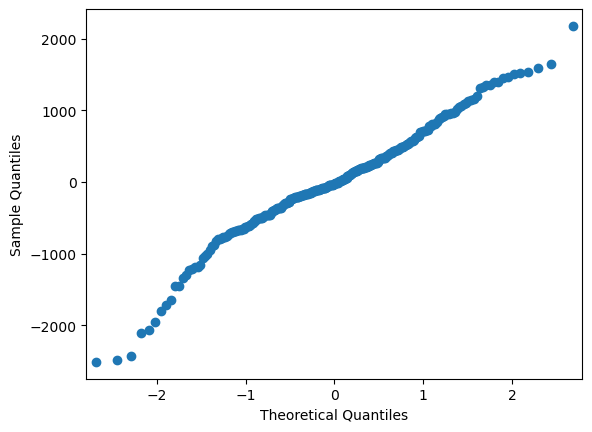

In [9]:
f = statsmodels.api.qqplot(model.resid)

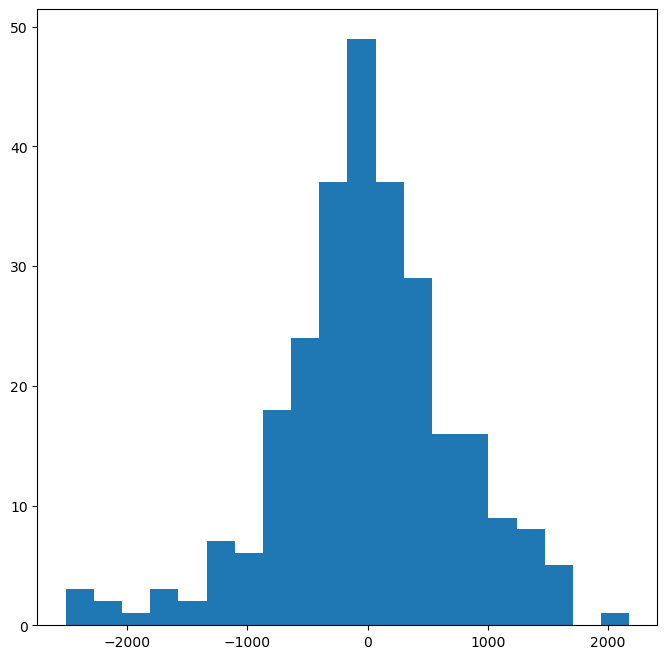

In [10]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.hist(model.resid, 20);

We can see in both cases here our model is not perfect, but it does at least roughly follow a normal distribution - though we do see that skew on the left of the histogram.

We can also visualise our residuals as per the plot below, via a scatter plot of the predictions and the residuals. 

Text(0, 0.5, 'Residual')

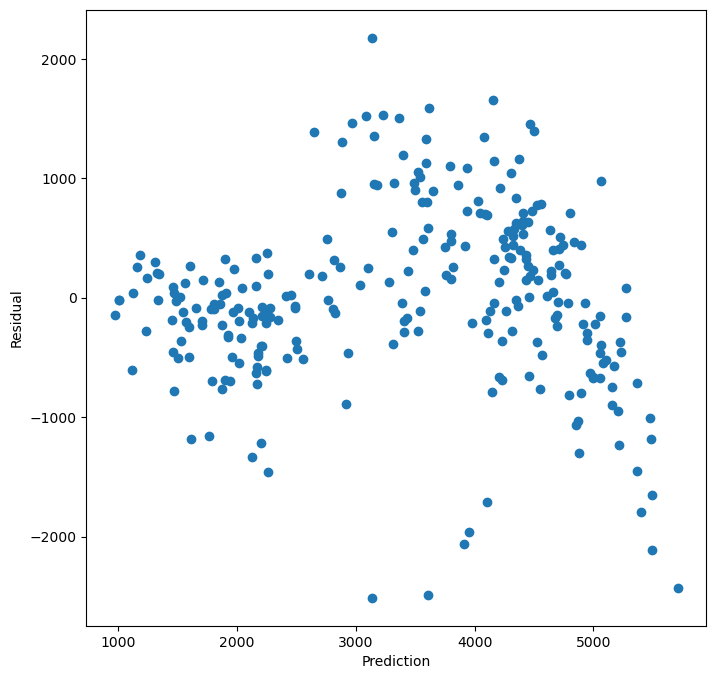

In [11]:
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(model.predict(data_train), model.resid);
ax.set_xlabel('Prediction')
ax.set_ylabel('Residual')

What we're looking for with this plot is that our errors are uniform. What this means is:
* We have symmetry about x=0, so we over- and under-estimate a roughly equal amount
* The y-axis spread is roughly equal across the whole range of values

Do we see this here? Probably not. If we break the x-axis into three groups we see:
* For predictions of rouglghly 1000-2500, our model has more negative residuals;
* From roughly 2500-4500, we have positiviely skewed residuals (though with a few massive negative outliers); and
* From roughly 4500 onwards, we're back to having way more negative residuals.

#### How broken is our model?

It's not catastropic - but it's not ideal either. We can certainly see that our residuals are roughly gaussian at best, and we have some variation in the spread of our residuals across the range of the data. Ideally, we'd like to improve this, but depending on the application this may or may not be a massive problem.

For example, if we're just trying to estimate the number of bikes in use to help plan maintenance, we can probably live with the model being a bit rougher.

### aTemp and Temp

A little while back we mentioned the weird discrepancy in the p-values, where temp and atemp seemed less important, despite being more highly correlated with the model target than the other parameters.

In [12]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     198.4
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           8.06e-79
Time:                        07:39:54   Log-Likelihood:                -2190.2
No. Observations:                 273   AIC:                             4390.
Df Residuals:                     268   BIC:                             4408.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1708.8451    296.956      5.755      0.0

This is down to the these terms being co-linear. If we look at some scatter plots again:

Text(0.5, 1.0, '0.9968816302544009')

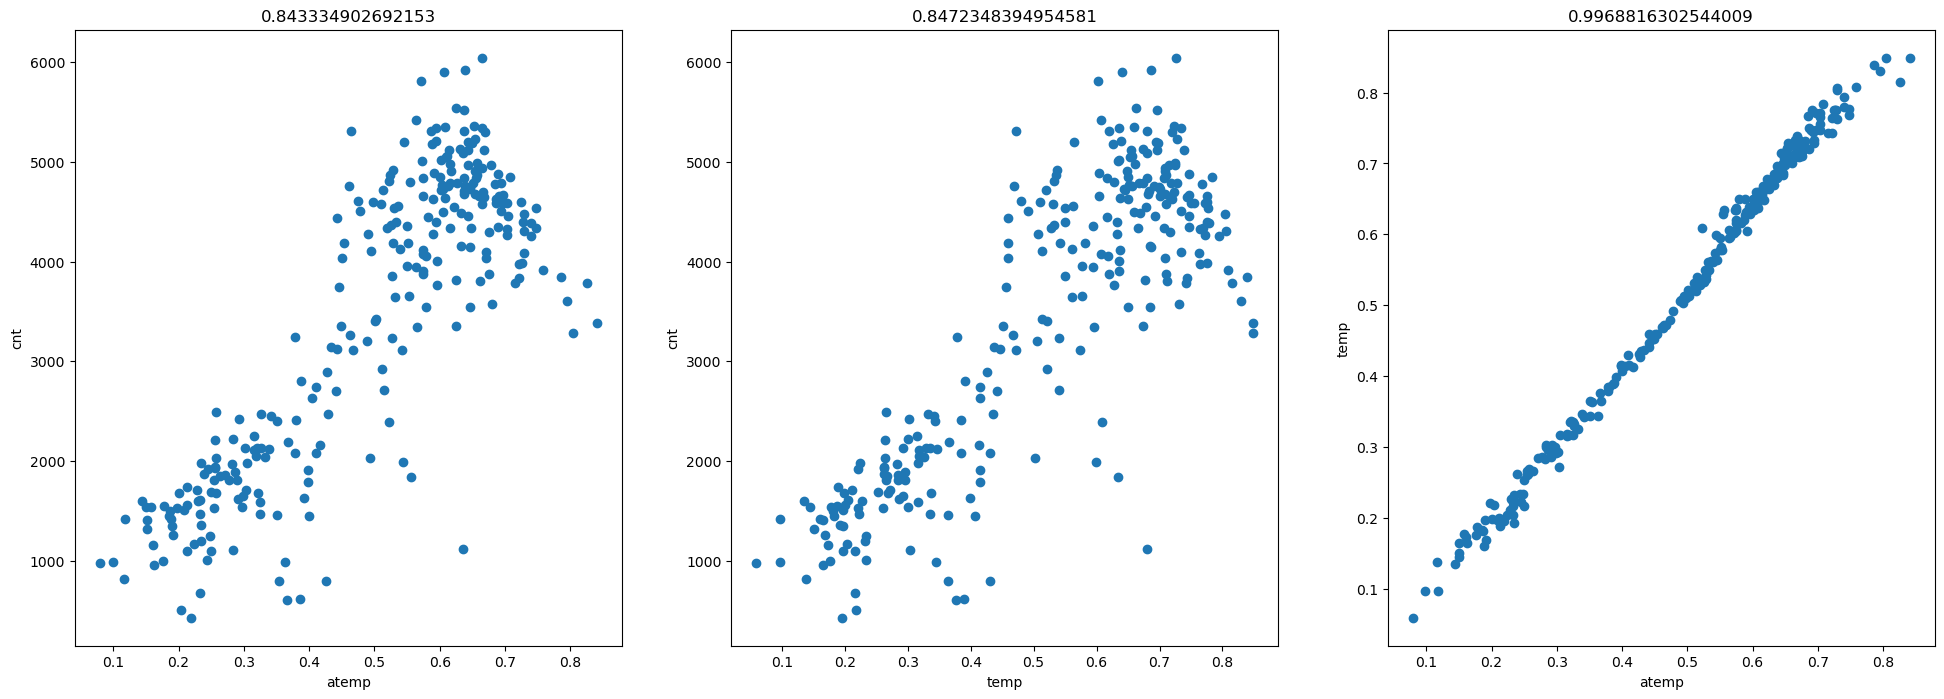

In [13]:
fig = plt.figure(figsize=[24, 8])
ax = fig.add_subplot(1, 3, 1)
ax.scatter(data_train['atemp'], data_train['cnt'])
ax.set_xlabel('atemp')
ax.set_ylabel('cnt')
ax.set_title(str(data_train['atemp'].corr(data_train['cnt'])))
ax = fig.add_subplot(1, 3, 2)
ax.scatter(data_train['temp'], data_train['cnt'])
ax.set_xlabel('temp')
ax.set_ylabel('cnt')
ax.set_title(str(data_train['temp'].corr(data_train['cnt'])))
ax = fig.add_subplot(1, 3, 3)
ax.scatter(data_train['atemp'], data_train['temp'])
ax.set_xlabel('atemp')
ax.set_ylabel('temp')
ax.set_title(str(data_train['atemp'].corr(data_train['temp'])))

What we see is that the scatter plot between `temp` and `cnt` looks very much like that between `atemp` and `cnt`, and `atemp` and `temp` and very highly correlated. Essentially, both of these variables are modelling the same thing, and so when both are fed into our linear regression, one is redundant, and so both have a lower importance.

Thinking about these variables, this makes sense. `aTemp` is the apparent temperature, and incorporates the actual air temp, the humidity and windspeed to give the temperature that it currently "feels like".

While for this model, looking at correlations individual on scatter plots is fine as we only have a few terms, when we get to bigger models this becomes totally impractical. Enter the heatmap.

<Axes: >

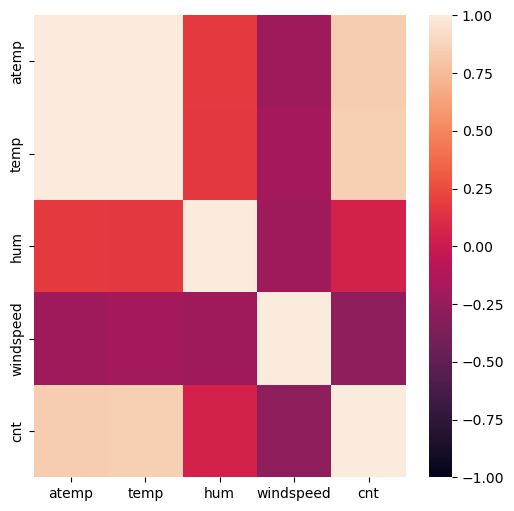

In [14]:
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
# concat X and y so that we get correlations between pairs of predictors, and correlations between 
# predictors and the response. As we've put these in the order [x, y], our correlations with the
# response will be the last column and row
seaborn.heatmap(data_train[["atemp", "temp", "hum", "windspeed", "cnt"]].corr(), ax=ax, vmin=-1.0, vmax=1.0)

Here, we're looking at the correlation between pairs of variables. The diagonal is the correlation between a variable and itself (which should always be 1), and the heat map is symmetrical either side of that. This further underscores the fact that atemp and temp are really pretty much identical.

### Analysing Predictions

Finally, let's have a look at our model's predictions. We'll plot a scatter plot of the predictions vs the actual values. Ideally, we'll see a strong linear relationship here. If we see weird shapes, it may indicate that we have some non-linear relationship somewhere that we're not capturing.

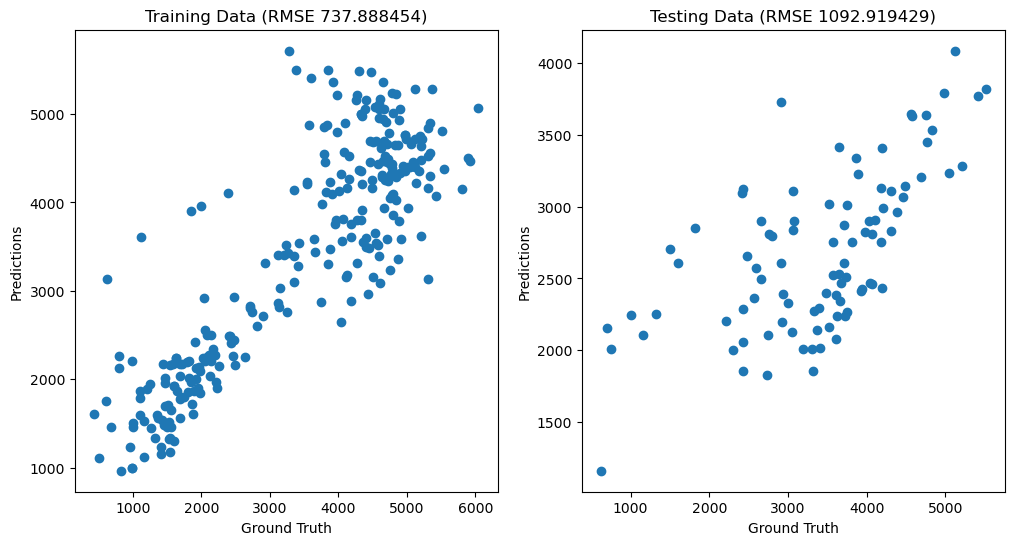

In [15]:
def plot_predictions(model, train, test):
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    rmse_train = numpy.sqrt(numpy.mean((pred_train - train['cnt'])**2))
    rmse_test = numpy.sqrt(numpy.mean((pred_test - test['cnt'])**2))

    fig = plt.figure(figsize=[12, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(train['cnt'], pred_train)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Predictions')
    ax.set_title('Training Data (RMSE %f)' % rmse_train)

    ax = fig.add_subplot(1, 2, 2)
    ax.scatter(test['cnt'], pred_test)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Predictions')
    ax.set_title('Testing Data (RMSE %f)' % rmse_test)
    
plot_predictions(model, data_train, data_test)

The above look ok, though we can see that we're doing worse on the test data than the training data, and that it does look a little bit less linear.

## Improving the model
Let's improve the model now. We'll drop the `atemp` variable, as we noted above that it's really a product of the other three variables. We'll also then print out the model summary, and have a look at our residuals.

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     264.2
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           7.43e-80
Time:                        07:39:55   Log-Likelihood:                -2190.7
No. Observations:                 273   AIC:                             4389.
Df Residuals:                     269   BIC:                             4404.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1598.9598    275.424      5.805      0.0

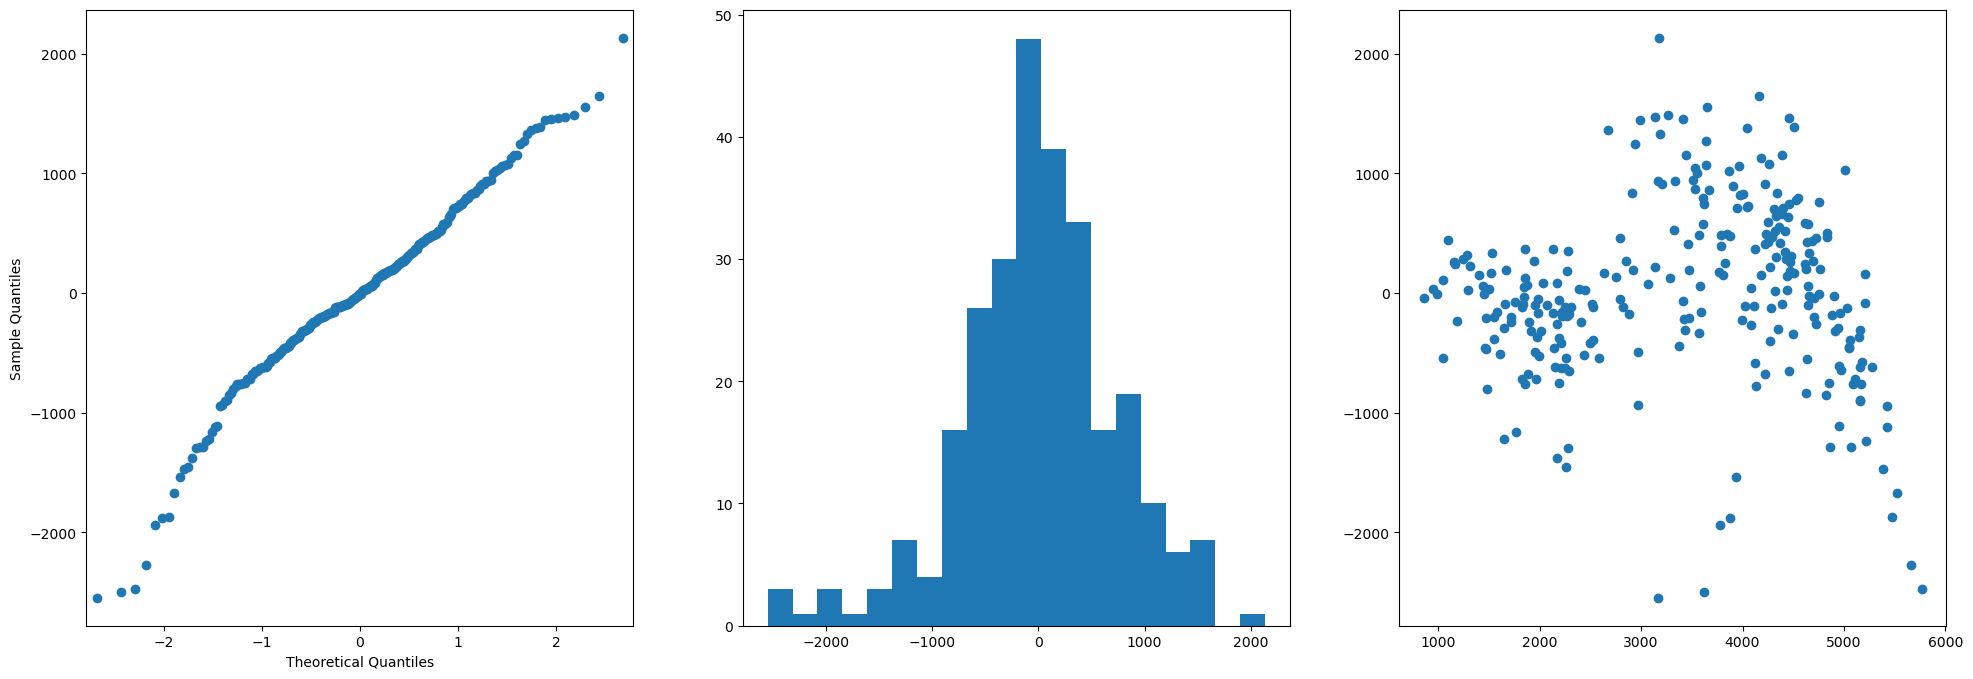

In [16]:
model_2 = sm.ols(formula="cnt ~ temp + hum + windspeed", data=data_train).fit()
print(model_2.summary())

def plot_diagnostics(model, training_data):
    fig = plt.figure(figsize=[24, 8])
    ax = fig.add_subplot(1, 3, 1)    
    f = statsmodels.api.qqplot(model.resid, ax=ax)

    ax = fig.add_subplot(1, 3, 2)
    ax.hist(model.resid, 20)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(model.predict(training_data), model.resid)
    
plot_diagnostics(model_2, data_train)

These look really similar to before - perhaps a bit better but any change is marginal.

The last thing we'll do is actually make some predictions with our model and plot them.

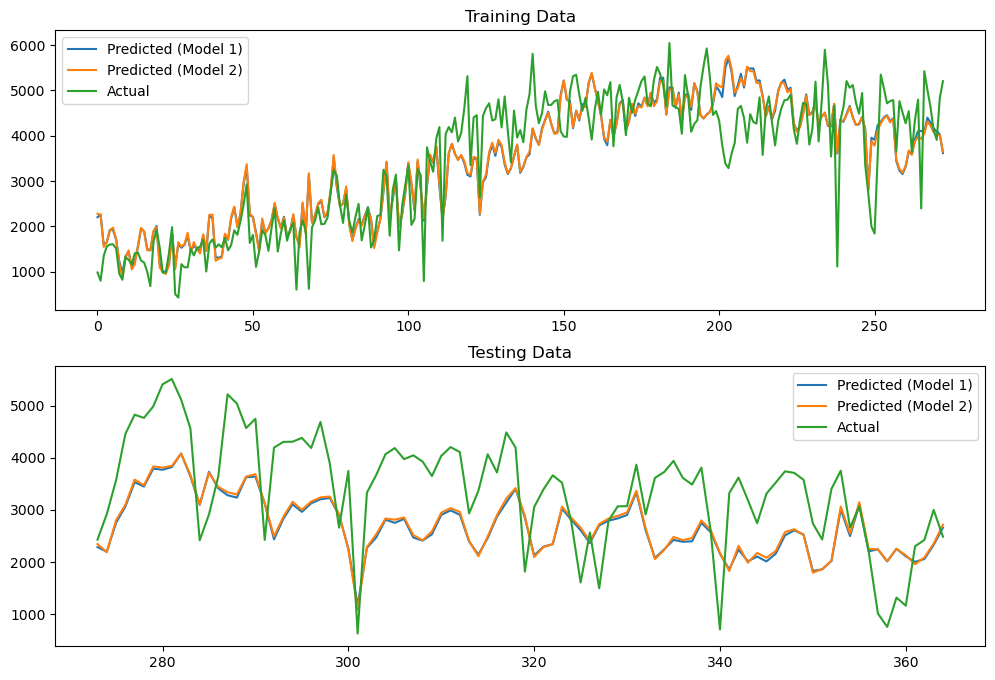

In [17]:
pred_train_orig = model.predict(data_train)
pred_test_orig = model.predict(data_test)
pred_train = model_2.predict(data_train)
pred_test = model_2.predict(data_test)
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(pred_train_orig, label='Predicted (Model 1)')
ax.plot(pred_train, label='Predicted (Model 2)')
ax.plot(data_train['cnt'], label='Actual')
ax.set_title('Training Data')
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(pred_test_orig, label='Predicted (Model 1)')
ax.plot(pred_test, label='Predicted (Model 2)')
ax.plot(data_test['cnt'], label='Actual')
ax.set_title('Testing Data')
ax.legend()

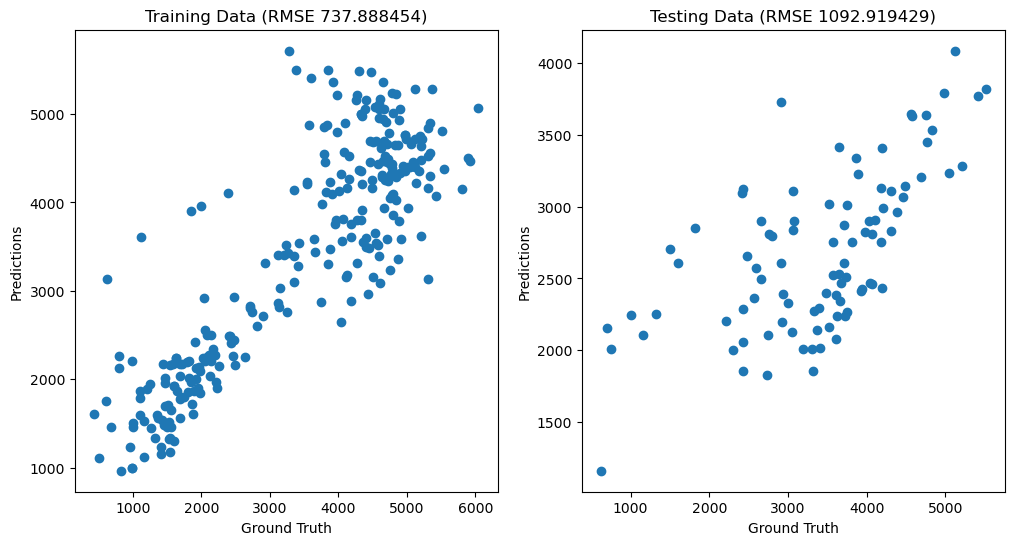

In [18]:
plot_predictions(model, data_train, data_test)

We can see our model is not great, and tends to under estimate the actual usage when it's high, and over-estimate when it's low. This backs up what we see in our qq-plot and the scatter plot of the predictions vs the residuals. That said, the peaks and troughs present in the data are followed fairly well by the model, so estimates generally go up and down when they're meant to (just not up and down far enough).

We also see that our two models are close to identical. This is not a shock, as the only variable we removed was essentially redundant. We can compute an error metric (such as root mean squared error) to further explore this:

In [19]:
import numpy
rmse_model1_train = numpy.sqrt(numpy.mean((pred_train_orig - data_train['cnt'])**2))
rmse_model1_test = numpy.sqrt(numpy.mean((pred_test_orig - data_test['cnt'])**2))
rmse_model2_train = numpy.sqrt(numpy.mean((pred_train - data_train['cnt'])**2))
rmse_model2_test = numpy.sqrt(numpy.mean((pred_test - data_test['cnt'])**2))

print('Model 1, Training Data RMSE: %f\nModel 1, Testing Data RMSE: %f\nModel 2, Training Data RMSE: %f\nModel 2, Testing Data RMSE: %f' % (rmse_model1_train, rmse_model1_test, rmse_model2_train, rmse_model2_test))

Model 1, Training Data RMSE: 737.888454
Model 1, Testing Data RMSE: 1092.919429
Model 2, Training Data RMSE: 739.236621
Model 2, Testing Data RMSE: 1071.677030


We can see errors are pretty similar between the two models, model 1 is slightly better on the training and data, and slightly worse on the test data, but there's not much in it.

In general, we may be concerned about the difference between train and test performance here. Often, having this gap between training and testing performance could indicate an element of overfitting, however we have a different situation going on here. We have data for a twelve month time period, and we've taken the last three months as our test set. Those three months have different weather conditions, and thus the reason for the loss of accuracy is more to do with the change in behaviour in the underlying system, and the fact that we may not have captured that properly in our model.

## Randomly Split Data

One possible problem we've got with our model is that we've trained it on Januray - September, and then tested it on October - December. We know that we've got a trend with bike usage increasing over time which we see from 2012 having way more users, and we've possibly also got some unseen weather conditions within the test data as well.

We can perform a random split on the data and re-train our model to see what happens. We get the following:

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     174.8
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           7.05e-63
Time:                        07:39:56   Log-Likelihood:                -2217.6
No. Observations:                 273   AIC:                             4443.
Df Residuals:                     269   BIC:                             4458.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2596.2207    313.254      8.288      0.0

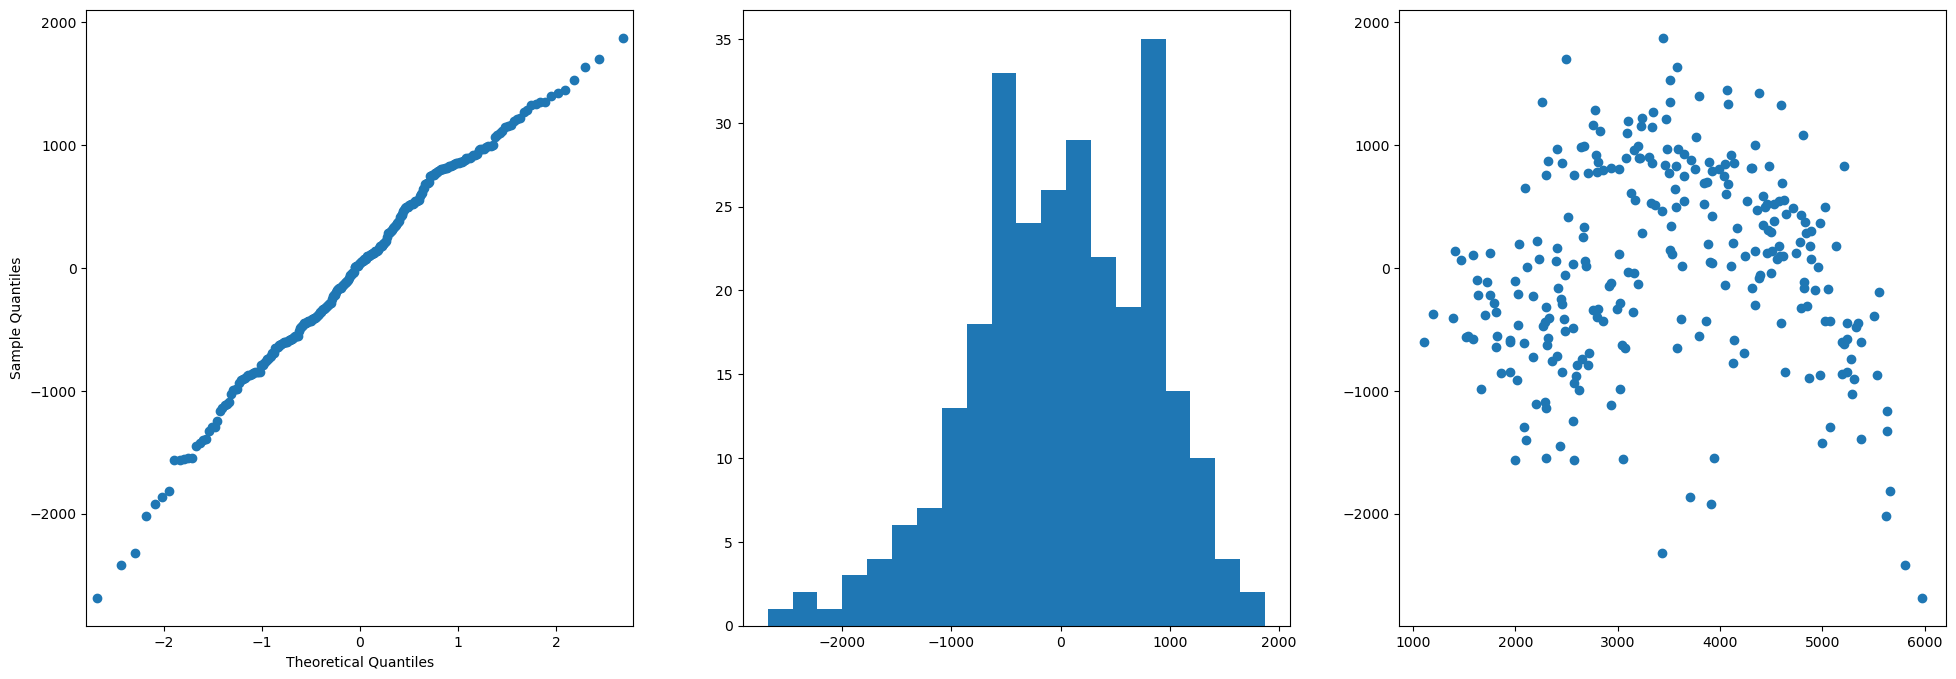

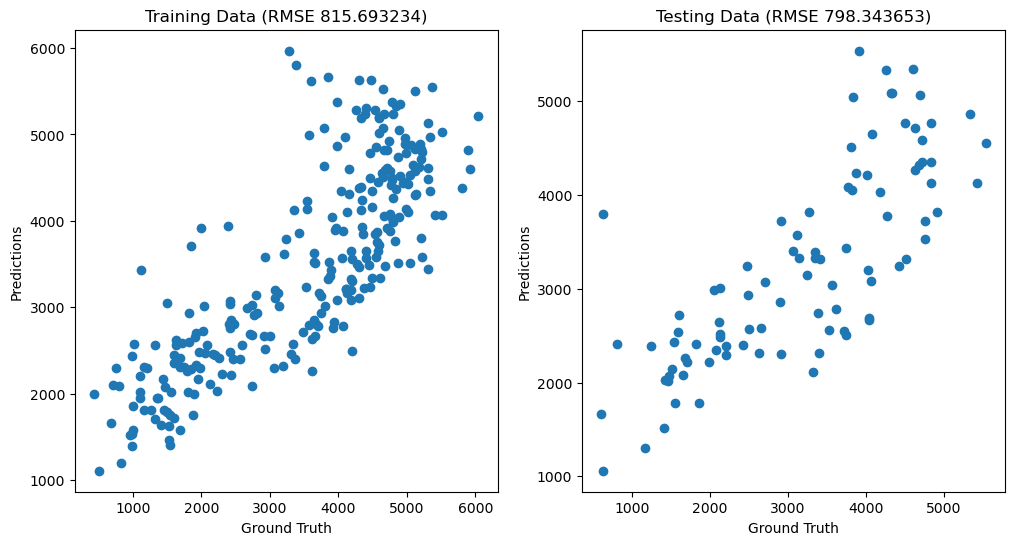

In [20]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data.loc[(data['yr'] == 0)], test_size=0.25, random_state=4)

model_3 = sm.ols(formula="cnt ~ temp + hum + windspeed", data=data_train).fit()
print(model_3.summary())
    
plot_diagnostics(model_3, data_train)
plot_predictions(model_3, data_train, data_test)

The model is fairly similar to what we had before in terms of parameters and goodness of fit. Our residual plots look a bit better, and while being far from perfect are certainly looking more like we'd hope. We can also see that the difference between the training set and testing set is smaller. 

By changing the way we've split the data, we now have the same data distribution in our train and test sets, so our model transfers between from one to the other as there is minimal disconnect there. This is something that we ideally always want - if the underlying structure or relationship in the data changes, then our model will likely suffer, so ensuring that our training set is properly representitive of what we are going to run it on is a really good idea (if it's possible and makes sense). 

Of course, when dealing with sequential data for a lot of reasons it makes sense to divide the data sequentially - i.e. do what we originally did and keep the first 9 months for the training and the rest for testing. I say this is better as it more accuratley simulates a real-world use case, i.e. we train the model on a bunch of historic data, and then test on new data as it's acquired.

One other big change here is that I've changed the way that I'm plotting things. Earlier I used a line graph. The line implies a relationship, i.e. one point is related to the next, which in a sense it is with this data as there is a temporal relationship. In those plots we could also (sort-of) see weekly patterns with dips in the plot corresponding to weekends with fewer commuters. Now however, with the data being randomly ordered, that relationship is gone. As such, I've plotted these as scatter plots comparing the actual values to the predictions.

## Making things more complex

Let's make the model more complex now, this will make it better (for a while), and ultimatley as we add too much complexity, make it worse.

### Categorical Variables

We have a lot of other terms in our model that we can use, though most of the other terms we have are categorical variables (all the variables we've used so far are continuous). We incorporate categorical variables differently. We'll include two:
* weekday, which is the day of the week
* season, which is the season of the year

Together, these will give our model more information about the day and time of year, and should help improve performance by allowing it to compensate for these factors.

First up, we need to make sure that the data is registered as being categorical. This means that rather than our data in these columns being able to take on any value, they are restricted to a set of fixed categories.

In [21]:
data_train["weekday"] = data_train["weekday"].astype("category")
data_train["season"] = data_train["season"].astype("category")

data_test["weekday"] = data_test["weekday"].astype("category")
data_test["season"] = data_test["season"].astype("category")

At this point we can then fit our model as we normally would, and statsmodels will correctly treat these two new variables as categorical types.

Note that depending on what package we're using for our regression, we may have to do this differently. Here, statsmodels is able to use the datatype information within the pandas table to work out how to handle each variable.  

In [22]:
model_4 = sm.ols(formula="cnt ~ temp + hum + windspeed + weekday + season", data=data_train).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     70.47
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           1.73e-74
Time:                        07:39:56   Log-Likelihood:                -2167.6
No. Observations:                 273   AIC:                             4361.
Df Residuals:                     260   BIC:                             4408.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2605.2645    286.406      9.096   

What that means is we get the above. We've added two variables, but got 9 new terms. The two variables we added have:
* 7 categories for week day
* 4 categories for season

We can look at these as not being 2 variables, but rather as being a set of 7 and a set of 4 mutally exclusive variables, which can either be true or false. Given that each of these can either be true or false, there is no "slope", just a constant. In effect, what happens is that each category adds a new intercept value that will be included when the appropriate category is set to true. The first category of each is incoroprated into the main intercept, hence we get (number of categories - 1) new terms.

Considering p-values for the terms, we consider these as a set, and if one value of the category is significant, we keep them all. In our case, we can see that weekday is not significant (all p values are well over 0.05), while for season all terms are significant.

We'll remove week day from the data, and re-train our model.

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     142.8
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           3.51e-80
Time:                        07:39:56   Log-Likelihood:                -2168.7
No. Observations:                 273   AIC:                             4351.
Df Residuals:                     266   BIC:                             4377.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2608.7335    270.398      9.648      

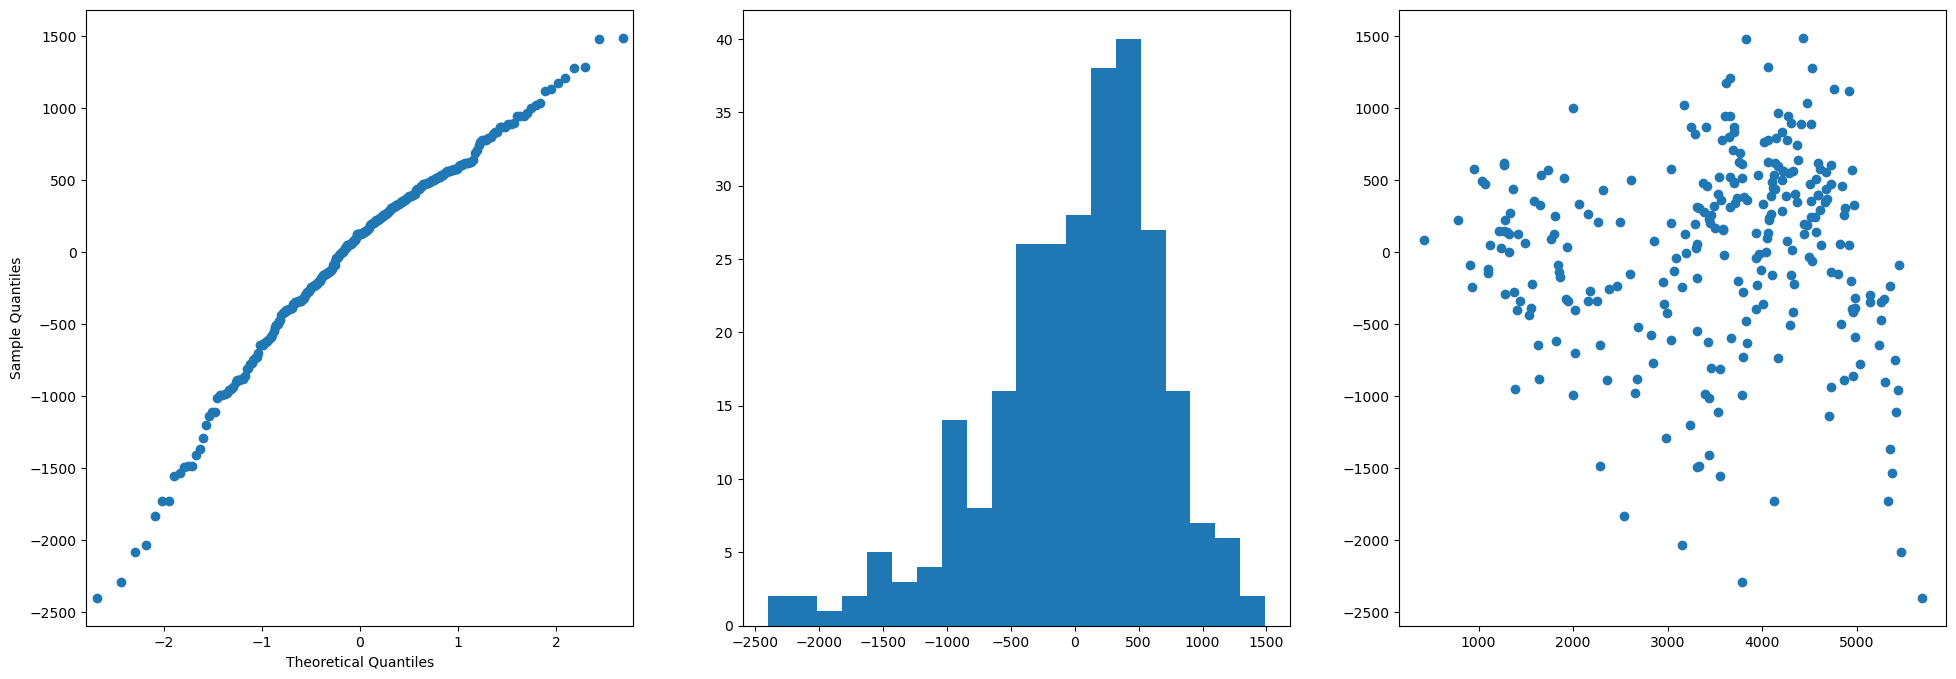

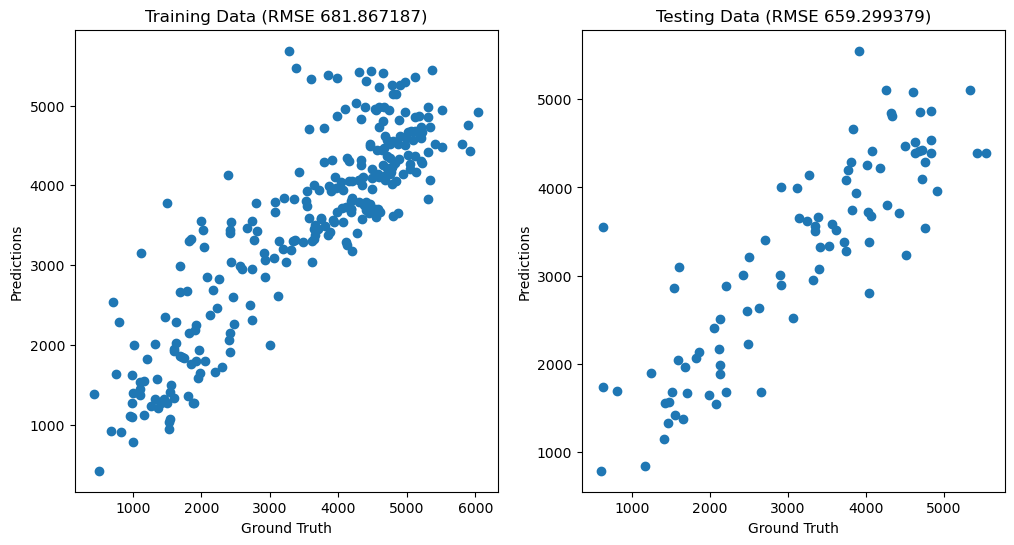

In [23]:
model_5 = sm.ols(formula="cnt ~ temp + hum + windspeed + season", data=data_train).fit()
print(model_5.summary())

plot_diagnostics(model_5, data_train)
plot_predictions(model_5, data_train, data_test)

We can see now that our model is much more accurate with that categorical term incorporated.

### Higher Order Terms and Overfitting

In general, as we add more and more terms, performance will improve. Terms do not have to be totally separate things either. We can create new terms (or features) by combining existing terms. In this case, we'll add interaction terms that capture the product of each term with each other term.

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     51.38
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           9.17e-89
Time:                        07:39:57   Log-Likelihood:                -2088.2
No. Observations:                 273   AIC:                             4240.
Df Residuals:                     241   BIC:                             4356.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

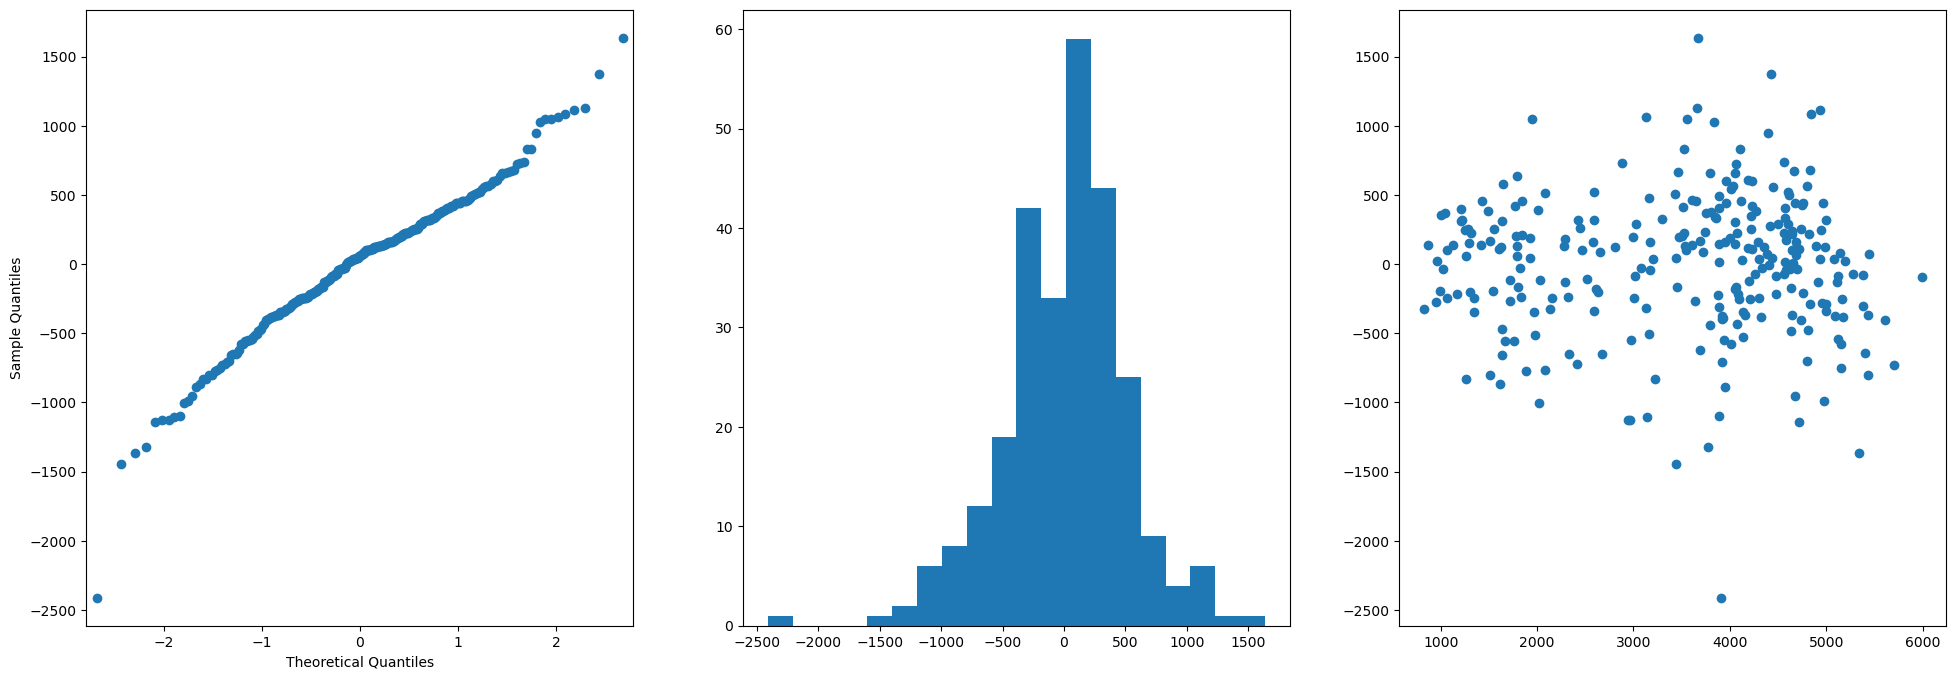

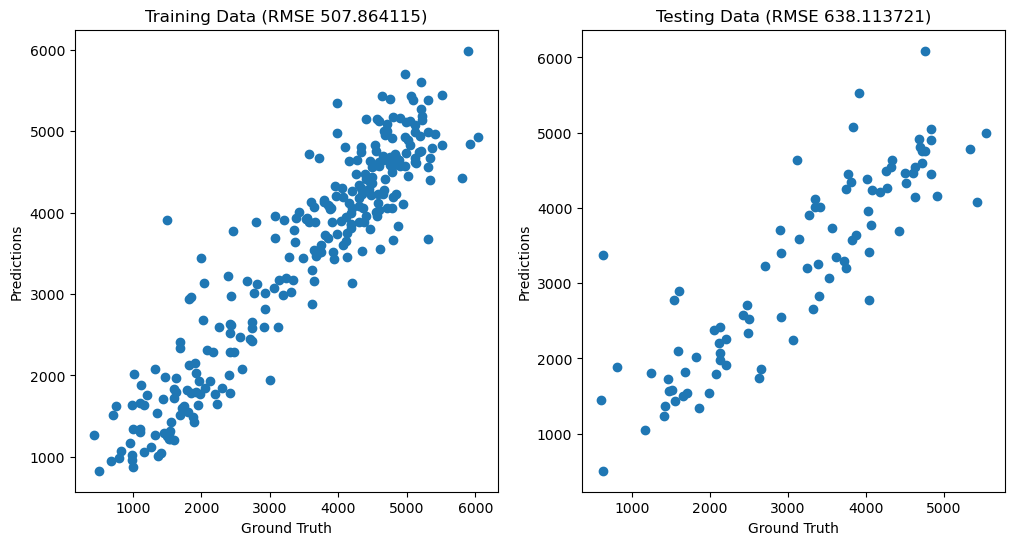

In [24]:
model_6 = sm.ols(formula="cnt ~ temp * hum * windspeed * season", data=data_train).fit()
print(model_6.summary())

plot_diagnostics(model_6, data_train)
plot_predictions(model_6, data_train, data_test)

We can see this gives us a much bigger model, but it's much more accurate too.

Of course we can go too far with this, and start to add in quatratic terms as well.

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     19.57
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           2.88e-10
Time:                        07:39:58   Log-Likelihood:                -1612.9
No. Observations:                 273   AIC:                             3732.
Df Residuals:                      20   BIC:                             4645.
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

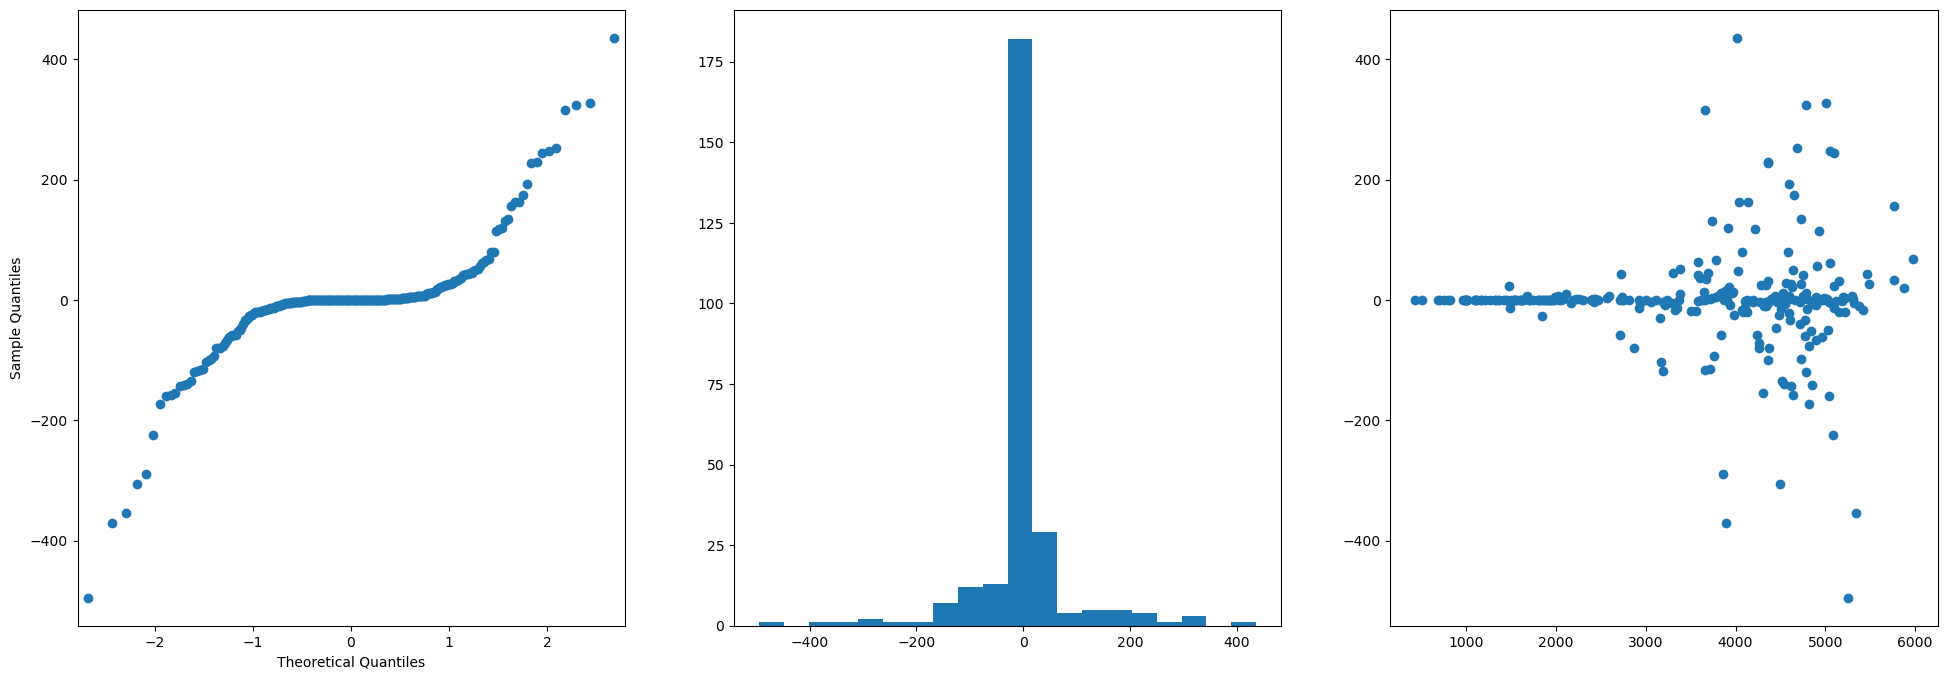

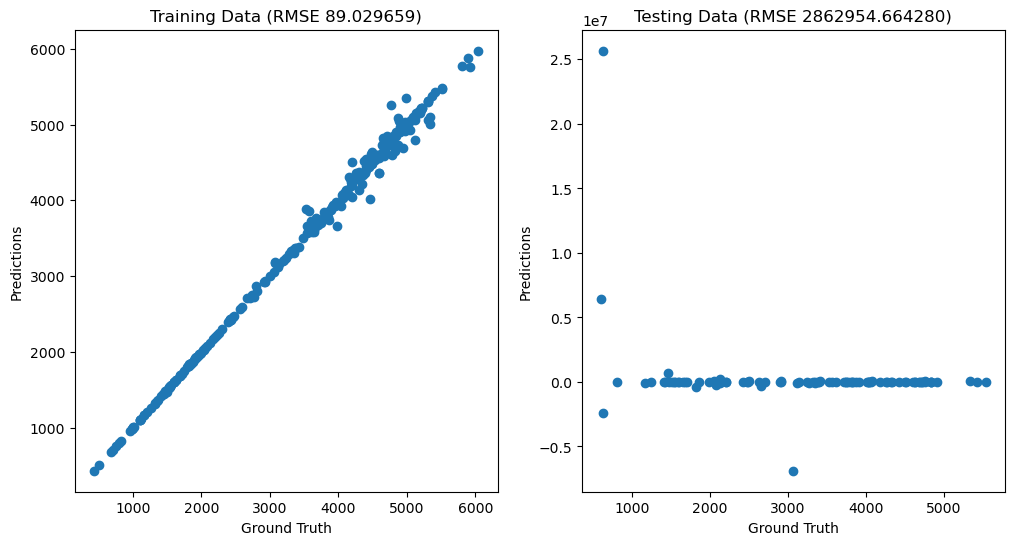

In [25]:
model_6 = sm.ols(formula="cnt ~ temp * hum * windspeed * season * numpy.power(temp, 2) * numpy.power(hum, 2) * numpy.power(windspeed, 2)", data=data_train).fit()
print(model_6.summary())

plot_diagnostics(model_6, data_train)
plot_predictions(model_6, data_train, data_test)

In this case we end up with a model that fits the training data almost perfectly, and fails totally on the testing data. This is a classic case of overfitting, and is something that can easily happen if we aren't careful and make our model too complex.

We can see our residual plots here are also hinting at the chaos we've unleashed:
* The qq-plot shows a massive amount of deviation for small and large values;
* The histgram show a very high peak with long tails around that peak, very much not a normal distribution:
* The scatter plot of predictions vs residuals shows a distribution that expands as predictions get larger. We see for smaller predicted values residuals are all very close to 0, but as we go towards the right in that plot, the spread increase (if there's a positive in this plot, it's that at least it's symmetric about x=0)

## Final Thoughts and Other Things

This example has looked at regression, and assessing model validity. There are few things to condiser when analysing a model, in no particular order these are:
* Is the model any good? $R^2$ and RMSE can help here
* Are all the terms important? p-values are your friend in this case, though be aware that there are issues with p-values, and in some contexts these are no longer widely used as the can be misused.
* If you need to remove terms because they have a poor p-value, it's important to check why this p-value is bad. Is it because the predictor and response are not related, or is it becuase the predictor is correlated with other predictors? Check the cross correlation between predictors to make sure that you're not accidently removing a useful term.
* The distribution of the residuals. These should be normally distributed, if they're not, then you're model is not valid, and may result in the some weird predictions. In practice, while we aim for normally distributed residuals, you will very rarely get results that fit the normal curve exceptionally well. If you consider what we've seen above, most of our models except for the final one (with the quadratic terms) were fairly good, and only our last one had any major problems in terms of the distribution of the residuals.
* Residuals should also have a consistent distribution across all predicted values. Where you see the distribution of the residuals changing, this may indicate an issue in the data, or missing information in the model.
* Categorical values can be incorporated into models, but need to be captured differently. These don't add a slope so much as a series of offsets for each category
* We can add higher order terms that capture more complex relationships in the data. This can greatly aid performance, but also expose us to the risk of overfitting.